In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
import tensorflow.python.keras as keras
from keras.layers import Input, Layer, LeakyReLU, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from keras.models import Model
from keras.optimizers import SGD
import keras.backend as K
import os
K.clear_session()
print("Running Tensorflow version", tf.__version__)

Using TensorFlow backend.


Running Tensorflow version 2.1.0


In [2]:
class RoundClampQ7_12(Layer):
    def __init__(self, **kwargs):
        super(RoundClampQ7_12, self).__init__(**kwargs)
    def call(self, X):
        return K.clip(K.round(X * 4096), -524288, 524287) / 4096.0
    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(RoundClampQ7_12, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
class RoundOverflowQ7_12(Layer):
    def __init__(self, **kwargs):
        super(RoundOverflowQ7_12, self).__init__(**kwargs)
    def call(self, X):
        return (((K.round(X * 4096) + 524288) % 1048576) - 524288) / 4096.0
    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(RoundOverflowQ7_12, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
class RoundClampQ3_4(Layer):
    def __init__(self, **kwargs):
        super(RoundClampQ3_4, self).__init__(**kwargs)
    def call(self, X):
        return K.clip(K.round(X * 16), -128, 127) / 16.0
    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(RoundClampQ3_4, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
class RoundOverflowQ3_4(Layer):
    def __init__(self, **kwargs):
        super(RoundOverflowQ3_4, self).__init__(**kwargs)
    def call(self, X):
        return (((K.round(X * 16) + 128) % 256) - 128) / 16.0
    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(RoundOverflowQ3_4, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
class Identity(Layer):
    def __init__(self, **kwargs):
        super(Identity, self).__init__(**kwargs)
    def call(self, X):
        return X
    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(Identity, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
# TODO: change IdentityFinalLayer into the final layer specified in https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg
# Reference: https://github.com/BoXiao123/py-tiny-yolo-from-scratch/blob/master/main.py
# Reference: https://github.com/BoXiao123/py-tiny-yolo-from-scratch/blob/master/forward_region.py
# Reference: https://blog.paperspace.com/how-to-implement-a-yolo-v3-object-detector-from-scratch-in-pytorch-part-2/
class IdentityFinalLayer(Layer):
    def __init__(self, **kwargs):
        super(IdentityFinalLayer, self).__init__(**kwargs)
    def call(self, X):
        return X
    def get_config(self):
        config = {"name": self.__class__.__name__}
        base_config = super(IdentityFinalLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
def DBL(previousLayer, layerFilter, kernelSize=(3, 3), roundingFunction=Identity()):
    return roundingFunction(LeakyReLU()(roundingFunction(BatchNormalization()(Conv2D(filters=layerFilter, kernel_size=kernelSize, padding='same')(previousLayer)))))
print("Custom layer classes successfully defined")

Custom layer classes successfully defined


loading annotations into memory...
Done (t=23.96s)
creating index...
index created!
Number of class classification is 80
{'license': 1, 'file_name': '000000536244.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000536244.jpg', 'height': 426, 'width': 640, 'date_captured': '2013-11-18 11:06:10', 'flickr_url': 'http://farm6.staticflickr.com/5062/5653849926_78393b4af0_z.jpg', 'id': 536244}


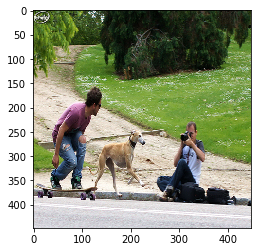

(448, 448, 3)

object 0
0 - [154.05, 232.22, 179.0, 135.98] 	category 18
object 1
1 - [51.18, 149.38, 150.34, 203.58] 	category 1
object 2
2 - [365.69, 220.18, 138.81, 159.87] 	category 1
object 3
3 - [8.91, 339.21, 179.4, 33.08] 	category 41
object 4
4 - [508.81, 343.46, 67.13, 35.67] 	category 33
object 5
5 - [438.42, 340.15, 68.77, 32.47] 	category 33
object 6
6 - [430.02, 334.8, 79.31, 42.13] 	category 27
Big Box
[18, [107.83, 244.21, 125.3, 143.0]]
[1, [35.82, 157.09, 105.23, 214.09]]
[1, [255.98, 231.55, 97.16, 168.12]]
Small Box
[41, [6.23, 356.72, 125.58, 34.78]]
[33, [356.16, 361.19, 46.99, 37.51]]
[33, [306.89, 357.71, 48.13, 34.14]]


In [3]:
#import matplotlib.pyplot as plt
#from PIL import Image
#import numpy as np
#import math

from pycocotools.coco import COCO

dataDir='.'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

coco=COCO(annFile)
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]

classificationClass = len(nms)
#classificationClass = 80 # testing purposes only
print("Number of class classification is", classificationClass)

imgIds = coco.getImgIds(catIds=coco.getCatIds(catNms=['person','dog','skateboard']));
img = coco.loadImgs(imgIds[int(len(imgIds) / 2)])[0]
print(img)
%matplotlib inline
imgLoad = Image.open('{}/{}/{}'.format(dataDir, dataType, img['file_name']))
imgWRatio = 448 / imgLoad.size[0]
imgHRatio = 448 / imgLoad.size[1]
imgLoad = np.asarray(imgLoad.resize((448,448)))
imgplot = plt.imshow(imgLoad)
plt.show()
print(np.array(imgLoad).shape)
print()
# print(coco.loadAnns(ids=coco.getAnnIds(imgIds=img['id'])))
bbox_array = list(map(lambda x: x['bbox'],coco.loadAnns(ids=coco.getAnnIds(imgIds=img['id']))))
cat_array = list(map(lambda x: x['category_id'],coco.loadAnns(ids=coco.getAnnIds(imgIds=img['id']))))
bigBox_array = []
smolBox_array = []
toAppendArray = []
for x in range(len(bbox_array)):
    print("object", x)
    print(x, "-", bbox_array[x], "\tcategory", cat_array[x])
    toAppendArray = bbox_array[x]
    toAppendArray[0] = math.floor(toAppendArray[0] * imgWRatio * 100) / 100
    toAppendArray[1] = math.floor(toAppendArray[1] * imgHRatio * 100) / 100
    toAppendArray[2] = math.floor(toAppendArray[2] * imgWRatio * 100) / 100
    toAppendArray[3] = math.floor(toAppendArray[3] * imgHRatio * 100) / 100
    if bbox_array[x][2] * bbox_array[x][3] > 10000:
        if len(bigBox_array) < 3:
            bigBox_array.append([cat_array[x], toAppendArray])
    else:
        if len(smolBox_array) < 3:
            smolBox_array.append([cat_array[x], toAppendArray])
# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
# https://www.immersivelimit.com/tutorials/create-coco-annotations-from-scratch
print('Big Box')
for p in range(len(bigBox_array)):
    print(bigBox_array[p])
print('Small Box')
for p in range(len(smolBox_array)):
    print(smolBox_array[p])
del coco

In [4]:
# model_0 does no rounding (float32 operation)
model_0_input = Input(shape=(448, 448, 3))
model_0_pointer = model_0_input
print("Input shape:", model_0_pointer.shape) # 448 x 448 x 3
model_0_startBranch = DBL(previousLayer=model_0_input, layerFilter=16) 
model_0_pointer = model_0_startBranch
print(model_0_pointer.shape) # 448 x 448 x 16
model_0_startBranch = MaxPooling2D(pool_size=(2, 2))(model_0_startBranch)
model_0_pointer = model_0_startBranch
print(model_0_pointer.shape) # 224 x 224 x 16
model_0_startBranch = DBL(previousLayer=model_0_startBranch, layerFilter=32)
model_0_pointer = model_0_startBranch
print(model_0_pointer.shape) # 224 x 224 x 32
model_0_startBranch = MaxPooling2D(pool_size=(2, 2))(model_0_startBranch)
model_0_pointer = model_0_startBranch
print(model_0_pointer.shape) # 112 x 112 x 32
model_0_startBranch = DBL(previousLayer=model_0_startBranch, layerFilter=64)
model_0_pointer = model_0_startBranch
print(model_0_pointer.shape) # 112 x 112 x 64
model_0_startBranch = MaxPooling2D(pool_size=(2, 2))(model_0_startBranch)
model_0_pointer = model_0_startBranch
print(model_0_pointer.shape) # 56 x 56 x 64
model_0_startBranch = DBL(previousLayer=model_0_startBranch, layerFilter=128)
model_0_pointer = model_0_startBranch
print(model_0_pointer.shape) # 56 x 56 x 128
model_0_startBranch = MaxPooling2D(pool_size=(2, 2))(model_0_startBranch)
model_0_pointer = model_0_startBranch
print(model_0_pointer.shape) # 28 x 28 x 128
model_0_startBranch = DBL(previousLayer=model_0_startBranch, layerFilter=256)
model_0_pointer = model_0_startBranch
print(model_0_pointer.shape) # 28 x 28 x 256
print("Branch split from main branch - following branch 0") # 2 branch split from startBranch (28 x 28 x 256), following model_0_branch0
model_0_branch0 = MaxPooling2D(pool_size=(2, 2))(model_0_startBranch)
model_0_pointer = model_0_branch0
print(model_0_pointer.shape) # 14 x 14 x 256
model_0_branch0 = DBL(previousLayer=model_0_branch0, layerFilter=512)
model_0_pointer = model_0_branch0
print(model_0_pointer.shape) # 14 x 14 x 512
model_0_branch0 = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(model_0_branch0)
model_0_pointer = model_0_branch0
print(model_0_pointer.shape) # 14 x 14 x 512
model_0_branch0 = DBL(previousLayer=model_0_branch0, layerFilter=1024)
model_0_pointer = model_0_branch0
print(model_0_pointer.shape) # 14 x 14 x 1024
model_0_branch0 = DBL(previousLayer=model_0_branch0, layerFilter=256, kernelSize=(1, 1))
model_0_pointer = model_0_branch0
print(model_0_pointer.shape) # 14 x 14 x 256
print("Branch split from branch 0 - following branch 0,0") # 2 branch split from model_0_branch0 (14 x 14 x 256), following model_0_branch00
model_0_branch00 = DBL(previousLayer=model_0_branch0, layerFilter=128, kernelSize=(1, 1))
model_0_pointer = model_0_branch00
print(model_0_pointer.shape) # 14 x 14 x 128
model_0_branch00 = UpSampling2D()(model_0_branch00)
model_0_pointer = model_0_branch00
print(model_0_pointer.shape) # 28 x 28 x 128
print("Branch merge from branch 1 and branch 0,0") # 2 branch merge from model_0_branch1 (unchanged from model_0_startBranch) and model_0_branch00
model_0_mergedBranch = Concatenate()([model_0_startBranch, model_0_branch00])
model_0_pointer = model_0_mergedBranch
print(model_0_pointer.shape) # 28 x 28 x 384
model_0_mergedBranch = DBL(previousLayer=model_0_mergedBranch, layerFilter=256)
model_0_pointer = model_0_mergedBranch
print(model_0_pointer.shape) # 28 x 28 x 256
model_0_mergedBranch = DBL(previousLayer=model_0_mergedBranch, layerFilter=3 * (4 + 1 + classificationClass))
model_0_pointer = model_0_mergedBranch
print("Model output 0 shape:", model_0_pointer.shape) # 28 x 28 x (3 * (5 + classificationClass))
model_0_mergedBranch = IdentityFinalLayer()(model_0_mergedBranch)
print() # OUTPUT = model_0_mergedBranch (note: 26 x 26 grid untuk deteksi objek kecil)

print("Branch split from branch 0 - following branch 0,1")# following model_0_branch01
model_0_branch01 = DBL(previousLayer=model_0_branch0, layerFilter=512)
model_0_pointer = model_0_branch01
print(model_0_pointer.shape) # 14 x 14 x 512
model_0_branch01 = DBL(previousLayer=model_0_branch01, layerFilter=3 * (4 + 1 + classificationClass))
model_0_pointer = model_0_branch01
print("Model output 1 shape:", model_0_pointer.shape) # 14 x 14 x (3 * (5 + classificationClass))
model_0_branch01 = IdentityFinalLayer()(model_0_branch01)
print() # OUTPUT = model_0_branch01 (note: 13 x 13 grid untuk deteksi objek besar)

model_0 = Model(inputs=model_0_input, outputs=[model_0_mergedBranch, model_0_branch01])
model_0.compile(optimizer=SGD(lr=0.001, decay=0.0005, momentum=0.9), loss='binary_crossentropy', loss_weights=[1., 0.2])
print("Model model_0 compilation complete")

Input shape: (None, 448, 448, 3)
(None, 448, 448, 16)
(None, 224, 224, 16)
(None, 224, 224, 32)
(None, 112, 112, 32)
(None, 112, 112, 64)
(None, 56, 56, 64)
(None, 56, 56, 128)
(None, 28, 28, 128)
(None, 28, 28, 256)
Branch split from main branch - following branch 0
(None, 14, 14, 256)
(None, 14, 14, 512)
(None, 14, 14, 512)
(None, 14, 14, 1024)
(None, 14, 14, 256)
Branch split from branch 0 - following branch 0,0
(None, 14, 14, 128)
(None, 28, 28, 128)
Branch merge from branch 1 and branch 0,0
(None, 28, 28, 384)
(None, 28, 28, 256)
Model output 0 shape: (None, 28, 28, 255)

Branch split from branch 0 - following branch 0,1
(None, 14, 14, 512)
Model output 1 shape: (None, 14, 14, 255)

Model model_0 compilation complete


In [5]:
# model_1 approximates Q7.12 signed fixed point operations with floating point rules (overflow = maximum/minimum value) 
# Done by rounding to the nearest 1/4096 and capping at [-128, 128) after batch normalization and activation layers
model_1_input = Input(shape=(448, 448, 3))
model_1_pointer = model_1_input
print("Input shape:", model_1_pointer.shape) # 448 x 448 x 3
model_1_startBranch = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_input, layerFilter=16) 
model_1_pointer = model_1_startBranch
print(model_1_pointer.shape) # 448 x 448 x 16
model_1_startBranch = MaxPooling2D(pool_size=(2, 2))(model_1_startBranch)
model_1_pointer = model_1_startBranch
print(model_1_pointer.shape) # 224 x 224 x 16
model_1_startBranch = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_startBranch, layerFilter=32)
model_1_pointer = model_1_startBranch
print(model_1_pointer.shape) # 224 x 224 x 32
model_1_startBranch = MaxPooling2D(pool_size=(2, 2))(model_1_startBranch)
model_1_pointer = model_1_startBranch
print(model_1_pointer.shape) # 112 x 112 x 32
model_1_startBranch = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_startBranch, layerFilter=64)
model_1_pointer = model_1_startBranch
print(model_1_pointer.shape) # 112 x 112 x 64
model_1_startBranch = MaxPooling2D(pool_size=(2, 2))(model_1_startBranch)
model_1_pointer = model_1_startBranch
print(model_1_pointer.shape) # 56 x 56 x 64
model_1_startBranch = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_startBranch, layerFilter=128)
model_1_pointer = model_1_startBranch
print(model_1_pointer.shape) # 56 x 56 x 128
model_1_startBranch = MaxPooling2D(pool_size=(2, 2))(model_1_startBranch)
model_1_pointer = model_1_startBranch
print(model_1_pointer.shape) # 28 x 28 x 128
model_1_startBranch = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_startBranch, layerFilter=256)
model_1_pointer = model_1_startBranch
print(model_1_pointer.shape) # 28 x 28 x 256
print("Branch split from main branch - following branch 0") # 2 branch split from startBranch (28 x 28 x 256), following model_1_branch0
model_1_branch0 = MaxPooling2D(pool_size=(2, 2))(model_1_startBranch)
model_1_pointer = model_1_branch0
print(model_1_pointer.shape) # 14 x 14 x 256
model_1_branch0 = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_branch0, layerFilter=512)
model_1_pointer = model_1_branch0
print(model_1_pointer.shape) # 14 x 14 x 512
model_1_branch0 = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(model_1_branch0)
model_1_pointer = model_1_branch0
print(model_1_pointer.shape) # 14 x 14 x 512
model_1_branch0 = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_branch0, layerFilter=1024)
model_1_pointer = model_1_branch0
print(model_1_pointer.shape) # 14 x 14 x 1024
model_1_branch0 = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_branch0, layerFilter=256, kernelSize=(1, 1))
model_1_pointer = model_1_branch0
print(model_1_pointer.shape) # 14 x 14 x 256
print("Branch split from branch 0 - following branch 0,0") # 2 branch split from model_1_branch0 (14 x 14 x 256), following model_1_branch00
model_1_branch00 = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_branch0, layerFilter=128, kernelSize=(1, 1))
model_1_pointer = model_1_branch00
print(model_1_pointer.shape) # 14 x 14 x 128
model_1_branch00 = UpSampling2D()(model_1_branch00)
model_1_pointer = model_1_branch00
print(model_1_pointer.shape) # 28 x 28 x 128
print("Branch merge from branch 1 and branch 0,0") # 2 branch merge from model_1_branch1 (unchanged from model_1_startBranch) and model_1_branch00
model_1_mergedBranch = Concatenate()([model_1_startBranch, model_1_branch00])
model_1_pointer = model_1_mergedBranch
print(model_1_pointer.shape) # 28 x 28 x 384
model_1_mergedBranch = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_mergedBranch, layerFilter=256)
model_1_pointer = model_1_mergedBranch
print(model_1_pointer.shape) # 28 x 28 x 256
model_1_mergedBranch = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_mergedBranch, layerFilter=3 * (4 + 1 + classificationClass))
model_1_pointer = model_1_mergedBranch
print("Model output 0 shape:", model_1_pointer.shape) # 28 x 28 x (3 * (5 + classificationClass))
model_1_mergedBranch = IdentityFinalLayer()(model_1_mergedBranch)
print() # OUTPUT = model_1_mergedBranch (note: 26 x 26 grid untuk deteksi objek kecil)

print("Branch split from branch 0 - following branch 0,1") # following model_1_branch01
model_1_branch01 = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_branch0, layerFilter=512)
model_1_pointer = model_1_branch01
print(model_1_pointer.shape) # 14 x 14 x 512
model_1_branch01 = DBL(roundingFunction=RoundClampQ7_12(), previousLayer=model_1_branch01, layerFilter=3 * (4 + 1 + classificationClass))
model_1_pointer = model_1_branch01
print("Model output 1 shape:", model_1_pointer.shape) # 14 x 14 x (3 * (5 + classificationClass))
model_1_branch01 = IdentityFinalLayer()(model_1_branch01)
print() # OUTPUT = model_1_branch01 (note: 13 x 13 grid untuk deteksi objek besar)

model_1 = Model(inputs=model_1_input, outputs=[model_1_mergedBranch, model_1_branch01])
model_1.compile(optimizer=SGD(lr=0.001, decay=0.0005, momentum=0.9), loss='binary_crossentropy', loss_weights=[1., 0.2])
print("Model model_1 compilation complete")

Input shape: (None, 448, 448, 3)
(None, 448, 448, 16)
(None, 224, 224, 16)
(None, 224, 224, 32)
(None, 112, 112, 32)
(None, 112, 112, 64)
(None, 56, 56, 64)
(None, 56, 56, 128)
(None, 28, 28, 128)
(None, 28, 28, 256)
Branch split from main branch - following branch 0
(None, 14, 14, 256)
(None, 14, 14, 512)
(None, 14, 14, 512)
(None, 14, 14, 1024)
(None, 14, 14, 256)
Branch split from branch 0 - following branch 0,0
(None, 14, 14, 128)
(None, 28, 28, 128)
Branch merge from branch 1 and branch 0,0
(None, 28, 28, 384)
(None, 28, 28, 256)
Model output 0 shape: (None, 28, 28, 255)

Branch split from branch 0 - following branch 0,1
(None, 14, 14, 512)
Model output 1 shape: (None, 14, 14, 255)

Model model_1 compilation complete


In [6]:
# model_2 approximates Q7.12 signed fixed point operations with integer rules (overflow = positive -> negative & vice versa) 
# Done by rounding to the nearest 1/4096 and capping at [-128, 128) after batch normalization and activation layers
model_2_input = Input(shape=(448, 448, 3))
model_2_pointer = model_2_input
print("Input shape:", model_2_pointer.shape) # 448 x 448 x 3
model_2_startBranch = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_input, layerFilter=16) 
model_2_pointer = model_2_startBranch
print(model_2_pointer.shape) # 448 x 448 x 16
model_2_startBranch = MaxPooling2D(pool_size=(2, 2))(model_2_startBranch)
model_2_pointer = model_2_startBranch
print(model_2_pointer.shape) # 224 x 224 x 16
model_2_startBranch = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_startBranch, layerFilter=32)
model_2_pointer = model_2_startBranch
print(model_2_pointer.shape) # 224 x 224 x 32
model_2_startBranch = MaxPooling2D(pool_size=(2, 2))(model_2_startBranch)
model_2_pointer = model_2_startBranch
print(model_2_pointer.shape) # 112 x 112 x 32
model_2_startBranch = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_startBranch, layerFilter=64)
model_2_pointer = model_2_startBranch
print(model_2_pointer.shape) # 112 x 112 x 64
model_2_startBranch = MaxPooling2D(pool_size=(2, 2))(model_2_startBranch)
model_2_pointer = model_2_startBranch
print(model_2_pointer.shape) # 56 x 56 x 64
model_2_startBranch = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_startBranch, layerFilter=128)
model_2_pointer = model_2_startBranch
print(model_2_pointer.shape) # 56 x 56 x 128
model_2_startBranch = MaxPooling2D(pool_size=(2, 2))(model_2_startBranch)
model_2_pointer = model_2_startBranch
print(model_2_pointer.shape) # 28 x 28 x 128
model_2_startBranch = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_startBranch, layerFilter=256)
model_2_pointer = model_2_startBranch
print(model_2_pointer.shape) # 28 x 28 x 256
print("Branch split from main branch - following branch 0") # 2 branch split from startBranch (28 x 28 x 256), following model_2_branch0
model_2_branch0 = MaxPooling2D(pool_size=(2, 2))(model_2_startBranch)
model_2_pointer = model_2_branch0
print(model_2_pointer.shape) # 14 x 14 x 256
model_2_branch0 = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_branch0, layerFilter=512)
model_2_pointer = model_2_branch0
print(model_2_pointer.shape) # 14 x 14 x 512
model_2_branch0 = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(model_2_branch0)
model_2_pointer = model_2_branch0
print(model_2_pointer.shape) # 14 x 14 x 512
model_2_branch0 = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_branch0, layerFilter=1024)
model_2_pointer = model_2_branch0
print(model_2_pointer.shape) # 14 x 14 x 1024
model_2_branch0 = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_branch0, layerFilter=256, kernelSize=(1, 1))
model_2_pointer = model_2_branch0
print(model_2_pointer.shape) # 14 x 14 x 256
print("Branch split from branch 0 - following branch 0,0") # 2 branch split from model_2_branch0 (14 x 14 x 256), following model_2_branch00
model_2_branch00 = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_branch0, layerFilter=128, kernelSize=(1, 1))
model_2_pointer = model_2_branch00
print(model_2_pointer.shape) # 14 x 14 x 128
model_2_branch00 = UpSampling2D()(model_2_branch00)
model_2_pointer = model_2_branch00
print(model_2_pointer.shape) # 28 x 28 x 128
print("Branch merge from branch 1 and branch 0,0") # 2 branch merge from model_2_branch1 (unchanged from model_2_startBranch) and model_2_branch00
model_2_mergedBranch = Concatenate()([model_2_startBranch, model_2_branch00])
model_2_pointer = model_2_mergedBranch
print(model_2_pointer.shape) # 28 x 28 x 384
model_2_mergedBranch = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_mergedBranch, layerFilter=256)
model_2_pointer = model_2_mergedBranch
print(model_2_pointer.shape) # 28 x 28 x 256
model_2_mergedBranch = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_mergedBranch, layerFilter=3 * (4 + 1 + classificationClass))
model_2_pointer = model_2_mergedBranch
print("Model output 0 shape:", model_2_pointer.shape) # 28 x 28 x (3 * (5 + classificationClass))
model_2_mergedBranch = IdentityFinalLayer()(model_2_mergedBranch)
print() # OUTPUT = model_2_mergedBranch (note: 26 x 26 grid untuk deteksi objek kecil)

print("Branch split from branch 0 - following branch 0,1")# following model_2_branch01
model_2_branch01 = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_branch0, layerFilter=512)
model_2_pointer = model_2_branch01
print(model_2_pointer.shape) # 14 x 14 x 512
model_2_branch01 = DBL(roundingFunction=RoundOverflowQ7_12(), previousLayer=model_2_branch01, layerFilter=3 * (4 + 1 + classificationClass))
model_2_pointer = model_2_branch01
print("Model output 1 shape:", model_2_pointer.shape) # 14 x 14 x (3 * (5 + classificationClass))
model_2_branch01 = IdentityFinalLayer()(model_2_branch01)
print() # OUTPUT = model_2_branch01 (note: 13 x 13 grid untuk deteksi objek besar)

model_2 = Model(inputs=model_2_input, outputs=[model_2_mergedBranch, model_2_branch01])
model_2.compile(optimizer=SGD(lr=0.001, decay=0.0005, momentum=0.9), loss='binary_crossentropy', loss_weights=[1., 0.2])
print("Model model_2 compilation complete")

Input shape: (None, 448, 448, 3)
(None, 448, 448, 16)
(None, 224, 224, 16)
(None, 224, 224, 32)
(None, 112, 112, 32)
(None, 112, 112, 64)
(None, 56, 56, 64)
(None, 56, 56, 128)
(None, 28, 28, 128)
(None, 28, 28, 256)
Branch split from main branch - following branch 0
(None, 14, 14, 256)
(None, 14, 14, 512)
(None, 14, 14, 512)
(None, 14, 14, 1024)
(None, 14, 14, 256)
Branch split from branch 0 - following branch 0,0
(None, 14, 14, 128)
(None, 28, 28, 128)
Branch merge from branch 1 and branch 0,0
(None, 28, 28, 384)
(None, 28, 28, 256)
Model output 0 shape: (None, 28, 28, 255)

Branch split from branch 0 - following branch 0,1
(None, 14, 14, 512)
Model output 1 shape: (None, 14, 14, 255)

Model model_2 compilation complete


In [7]:
# model_3 approximates Q3.4 signed fixed point operations with floating point rules (overflow = maximum/minimum value) 
# Done by rounding to the nearest 1/16 and capping at [-8, 8) after batch normalization and activation layers
model_3_input = Input(shape=(448, 448, 3))
model_3_pointer = model_3_input
print("Input shape:", model_3_pointer.shape) # 448 x 448 x 3
model_3_startBranch = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_input, layerFilter=16) 
model_3_pointer = model_3_startBranch
print(model_3_pointer.shape) # 448 x 448 x 16
model_3_startBranch = MaxPooling2D(pool_size=(2, 2))(model_3_startBranch)
model_3_pointer = model_3_startBranch
print(model_3_pointer.shape) # 224 x 224 x 16
model_3_startBranch = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_startBranch, layerFilter=32)
model_3_pointer = model_3_startBranch
print(model_3_pointer.shape) # 224 x 224 x 32
model_3_startBranch = MaxPooling2D(pool_size=(2, 2))(model_3_startBranch)
model_3_pointer = model_3_startBranch
print(model_3_pointer.shape) # 112 x 112 x 32
model_3_startBranch = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_startBranch, layerFilter=64)
model_3_pointer = model_3_startBranch
print(model_3_pointer.shape) # 112 x 112 x 64
model_3_startBranch = MaxPooling2D(pool_size=(2, 2))(model_3_startBranch)
model_3_pointer = model_3_startBranch
print(model_3_pointer.shape) # 56 x 56 x 64
model_3_startBranch = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_startBranch, layerFilter=128)
model_3_pointer = model_3_startBranch
print(model_3_pointer.shape) # 56 x 56 x 128
model_3_startBranch = MaxPooling2D(pool_size=(2, 2))(model_3_startBranch)
model_3_pointer = model_3_startBranch
print(model_3_pointer.shape) # 28 x 28 x 128
model_3_startBranch = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_startBranch, layerFilter=256)
model_3_pointer = model_3_startBranch
print(model_3_pointer.shape) # 28 x 28 x 256
print("Branch split from main branch - following branch 0") # 2 branch split from startBranch (28 x 28 x 256), following model_3_branch0
model_3_branch0 = MaxPooling2D(pool_size=(2, 2))(model_3_startBranch)
model_3_pointer = model_3_branch0
print(model_3_pointer.shape) # 14 x 14 x 256
model_3_branch0 = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_branch0, layerFilter=512)
model_3_pointer = model_3_branch0
print(model_3_pointer.shape) # 14 x 14 x 512
model_3_branch0 = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(model_3_branch0)
model_3_pointer = model_3_branch0
print(model_3_pointer.shape) # 14 x 14 x 512
model_3_branch0 = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_branch0, layerFilter=1024)
model_3_pointer = model_3_branch0
print(model_3_pointer.shape) # 14 x 14 x 1024
model_3_branch0 = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_branch0, layerFilter=256, kernelSize=(1, 1))
model_3_pointer = model_3_branch0
print(model_3_pointer.shape) # 14 x 14 x 256
print("Branch split from branch 0 - following branch 0,0") # 2 branch split from model_3_branch0 (14 x 14 x 256), following model_3_branch00
model_3_branch00 = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_branch0, layerFilter=128, kernelSize=(1, 1))
model_3_pointer = model_3_branch00
print(model_3_pointer.shape) # 14 x 14 x 128
model_3_branch00 = UpSampling2D()(model_3_branch00)
model_3_pointer = model_3_branch00
print(model_3_pointer.shape) # 28 x 28 x 128
print("Branch merge from branch 1 and branch 0,0") # 2 branch merge from model_3_branch1 (unchanged from model_3_startBranch) and model_3_branch00
model_3_mergedBranch = Concatenate()([model_3_startBranch, model_3_branch00])
model_3_pointer = model_3_mergedBranch
print(model_3_pointer.shape) # 28 x 28 x 384
model_3_mergedBranch = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_mergedBranch, layerFilter=256)
model_3_pointer = model_3_mergedBranch
print(model_3_pointer.shape) # 28 x 28 x 256
model_3_mergedBranch = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_mergedBranch, layerFilter=3 * (4 + 1 + classificationClass))
model_3_pointer = model_3_mergedBranch
print("Model output 0 shape:", model_3_pointer.shape) # 28 x 28 x (3 * (5 + classificationClass))
model_3_mergedBranch = IdentityFinalLayer()(model_3_mergedBranch)
print() # OUTPUT = model_3_mergedBranch (note: 26 x 26 grid untuk deteksi objek kecil)

print("Branch split from branch 0 - following branch 0,1") # following model_3_branch01
model_3_branch01 = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_branch0, layerFilter=512)
model_3_pointer = model_3_branch01
print(model_3_pointer.shape) # 14 x 14 x 512
model_3_branch01 = DBL(roundingFunction=RoundClampQ3_4(), previousLayer=model_3_branch01, layerFilter=3 * (4 + 1 + classificationClass))
model_3_pointer = model_3_branch01
print("Model output 1 shape:", model_3_pointer.shape) # 14 x 14 x (3 * (5 + classificationClass))
model_3_branch01 = IdentityFinalLayer()(model_3_branch01)
print() # OUTPUT = model_3_branch01 (note: 13 x 13 grid untuk deteksi objek besar)

model_3 = Model(inputs=model_3_input, outputs=[model_3_mergedBranch, model_3_branch01])
model_3.compile(optimizer=SGD(lr=0.001, decay=0.0005, momentum=0.9), loss='binary_crossentropy', loss_weights=[1., 0.2])
print("Model model_3 compilation complete")

Input shape: (None, 448, 448, 3)
(None, 448, 448, 16)
(None, 224, 224, 16)
(None, 224, 224, 32)
(None, 112, 112, 32)
(None, 112, 112, 64)
(None, 56, 56, 64)
(None, 56, 56, 128)
(None, 28, 28, 128)
(None, 28, 28, 256)
Branch split from main branch - following branch 0
(None, 14, 14, 256)
(None, 14, 14, 512)
(None, 14, 14, 512)
(None, 14, 14, 1024)
(None, 14, 14, 256)
Branch split from branch 0 - following branch 0,0
(None, 14, 14, 128)
(None, 28, 28, 128)
Branch merge from branch 1 and branch 0,0
(None, 28, 28, 384)
(None, 28, 28, 256)
Model output 0 shape: (None, 28, 28, 255)

Branch split from branch 0 - following branch 0,1
(None, 14, 14, 512)
Model output 1 shape: (None, 14, 14, 255)

Model model_3 compilation complete


In [8]:
# model_4 approximates Q3.4 signed fixed point operations with integer rules (overflow = positive -> negative & vice versa) 
# Done by rounding to the nearest 1/16 and capping at [-8, 8) after batch normalization and activation layers
model_4_input = Input(shape=(448, 448, 3))
model_4_pointer = model_4_input
print("Input shape:", model_4_pointer.shape) # 448 x 448 x 3
model_4_startBranch = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_input, layerFilter=16) 
model_4_pointer = model_4_startBranch
print(model_4_pointer.shape) # 448 x 448 x 16
model_4_startBranch = MaxPooling2D(pool_size=(2, 2))(model_4_startBranch)
model_4_pointer = model_4_startBranch
print(model_4_pointer.shape) # 224 x 224 x 16
model_4_startBranch = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_startBranch, layerFilter=32)
model_4_pointer = model_4_startBranch
print(model_4_pointer.shape) # 224 x 224 x 32
model_4_startBranch = MaxPooling2D(pool_size=(2, 2))(model_4_startBranch)
model_4_pointer = model_4_startBranch
print(model_4_pointer.shape) # 112 x 112 x 32
model_4_startBranch = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_startBranch, layerFilter=64)
model_4_pointer = model_4_startBranch
print(model_4_pointer.shape) # 112 x 112 x 64
model_4_startBranch = MaxPooling2D(pool_size=(2, 2))(model_4_startBranch)
model_4_pointer = model_4_startBranch
print(model_4_pointer.shape) # 56 x 56 x 64
model_4_startBranch = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_startBranch, layerFilter=128)
model_4_pointer = model_4_startBranch
print(model_4_pointer.shape) # 56 x 56 x 128
model_4_startBranch = MaxPooling2D(pool_size=(2, 2))(model_4_startBranch)
model_4_pointer = model_4_startBranch
print(model_4_pointer.shape) # 28 x 28 x 128
model_4_startBranch = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_startBranch, layerFilter=256)
model_4_pointer = model_4_startBranch
print(model_4_pointer.shape) # 28 x 28 x 256
print("Branch split from main branch - following branch 0") # 2 branch split from startBranch (28 x 28 x 256), following model_4_branch0
model_4_branch0 = MaxPooling2D(pool_size=(2, 2))(model_4_startBranch)
model_4_pointer = model_4_branch0
print(model_4_pointer.shape) # 14 x 14 x 256
model_4_branch0 = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_branch0, layerFilter=512)
model_4_pointer = model_4_branch0
print(model_4_pointer.shape) # 14 x 14 x 512
model_4_branch0 = MaxPooling2D(pool_size=(2, 2), strides=1, padding='same')(model_4_branch0)
model_4_pointer = model_4_branch0
print(model_4_pointer.shape) # 14 x 14 x 512
model_4_branch0 = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_branch0, layerFilter=1024)
model_4_pointer = model_4_branch0
print(model_4_pointer.shape) # 14 x 14 x 1024
model_4_branch0 = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_branch0, layerFilter=256, kernelSize=(1, 1))
model_4_pointer = model_4_branch0
print(model_4_pointer.shape) # 14 x 14 x 256
print("Branch split from branch 0 - following branch 0,0") # 2 branch split from model_4_branch0 (14 x 14 x 256), following model_4_branch00
model_4_branch00 = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_branch0, layerFilter=128, kernelSize=(1, 1))
model_4_pointer = model_4_branch00
print(model_4_pointer.shape) # 14 x 14 x 128
model_4_branch00 = UpSampling2D()(model_4_branch00)
model_4_pointer = model_4_branch00
print(model_4_pointer.shape) # 28 x 28 x 128
print("Branch merge from branch 1 and branch 0,0") # 2 branch merge from model_4_branch1 (unchanged from model_4_startBranch) and model_4_branch00
model_4_mergedBranch = Concatenate()([model_4_startBranch, model_4_branch00])
model_4_pointer = model_4_mergedBranch
print(model_4_pointer.shape) # 28 x 28 x 384
model_4_mergedBranch = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_mergedBranch, layerFilter=256)
model_4_pointer = model_4_mergedBranch
print(model_4_pointer.shape) # 28 x 28 x 256
model_4_mergedBranch = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_mergedBranch, layerFilter=3 * (4 + 1 + classificationClass))
model_4_pointer = model_4_mergedBranch
print("Model output 0 shape:", model_4_pointer.shape) # 28 x 28 x (3 * (5 + classificationClass))
model_4_mergedBranch = IdentityFinalLayer()(model_4_mergedBranch)
print() # OUTPUT = model_4_mergedBranch (note: 26 x 26 grid untuk deteksi objek kecil)

print("Branch split from branch 0 - following branch 0,1")# following model_4_branch01
model_4_branch01 = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_branch0, layerFilter=512)
model_4_pointer = model_4_branch01
print(model_4_pointer.shape) # 14 x 14 x 512
model_4_branch01 = DBL(roundingFunction=RoundOverflowQ3_4(), previousLayer=model_4_branch01, layerFilter=3 * (4 + 1 + classificationClass))
model_4_pointer = model_4_branch01
print("Model output 1 shape:", model_4_pointer.shape) # 14 x 14 x (3 * (5 + classificationClass))
model_4_branch01 = IdentityFinalLayer()(model_4_branch01)
print() # OUTPUT = model_4_branch01 (note: 13 x 13 grid untuk deteksi objek besar)

model_4 = Model(inputs=model_4_input, outputs=[model_4_mergedBranch, model_4_branch01])
model_4.compile(optimizer=SGD(lr=0.001, decay=0.0005, momentum=0.9), loss='binary_crossentropy', loss_weights=[1., 0.2])
print("Model model_4 compilation complete")

Input shape: (None, 448, 448, 3)
(None, 448, 448, 16)
(None, 224, 224, 16)
(None, 224, 224, 32)
(None, 112, 112, 32)
(None, 112, 112, 64)
(None, 56, 56, 64)
(None, 56, 56, 128)
(None, 28, 28, 128)
(None, 28, 28, 256)
Branch split from main branch - following branch 0
(None, 14, 14, 256)
(None, 14, 14, 512)
(None, 14, 14, 512)
(None, 14, 14, 1024)
(None, 14, 14, 256)
Branch split from branch 0 - following branch 0,0
(None, 14, 14, 128)
(None, 28, 28, 128)
Branch merge from branch 1 and branch 0,0
(None, 28, 28, 384)
(None, 28, 28, 256)
Model output 0 shape: (None, 28, 28, 255)

Branch split from branch 0 - following branch 0,1
(None, 14, 14, 512)
Model output 1 shape: (None, 14, 14, 255)

Model model_4 compilation complete


In [9]:
print(model_0.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 448, 448, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 448, 448, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
identity_1 (Identity)           multiple             0           batch_normalization_1[0][0]      
                                                                 leaky_re_lu_1[0][0]        

In [10]:
print(model_1.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 448, 448, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 448, 448, 16) 64          conv2d_14[0][0]                  
__________________________________________________________________________________________________
round_clamp_q7_12_1 (RoundClamp (None, 448, 448, 16) 0           batch_normalization_14[0][0]     
                                                                 leaky_re_lu_14[0][0]       

In [11]:
print(model_2.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 448, 448, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 448, 448, 16) 64          conv2d_27[0][0]                  
__________________________________________________________________________________________________
round_overflow_q7_12_1 (RoundOv (None, 448, 448, 16) 0           batch_normalization_27[0][0]     
                                                                 leaky_re_lu_27[0][0]       

In [12]:
print(model_3.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 448, 448, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 448, 448, 16) 64          conv2d_40[0][0]                  
__________________________________________________________________________________________________
round_clamp_q3_4_1 (RoundClampQ (None, 448, 448, 16) 0           batch_normalization_40[0][0]     
                                                                 leaky_re_lu_40[0][0]       

In [13]:
print(model_4.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
conv2d_53 (Conv2D)              (None, 448, 448, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 448, 448, 16) 64          conv2d_53[0][0]                  
__________________________________________________________________________________________________
round_overflow_q3_4_1 (RoundOve (None, 448, 448, 16) 0           batch_normalization_53[0][0]     
                                                                 leaky_re_lu_53[0][0]       